# **SVHN Dataset**
In the following exercices, you will work with the SVHN dataset: http://ufldl.stanford.edu/housenumbers/

It contains RGB images of street digits labeled from 1 to 10 similar to the MNIST dataset.

The train and test sets are provided in the folder Data/svhn/ in .mat format.
In the following we show an example of how to load the images and labels from these files. A DataLoader for this dataset is provided in the code examples for the lab.

labels:  (73257,) images:  (32, 32, 3, 73257)
Label: 9


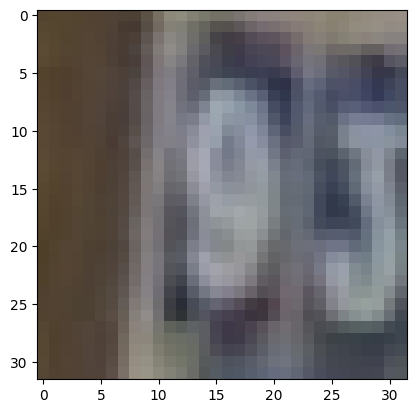

In [2]:
# Basic example loading images from the svhn dataset
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

try: 
    base_path
except NameError:
    base_path = os.getcwd().replace('\\','/')
data_path = base_path + '/Data/'
results_path = base_path + '/Results/'

# Load mat file with train images from SVHN
import scipy.io as sio
train_mat = sio.loadmat(data_path + 'svhn/train_32x32.mat')

images = train_mat['X']
labels = train_mat['y'].squeeze()

example_image, example_label = images[:,:,:,6], labels[6] 
print("labels: ", labels.shape, "images: ", images.shape)
print('Label: ' + str(example_label))
plt.imshow(example_image)

# Ex. 1


'''
1. Try to obtain the maximum test accuracy possible in the SVHN dataset. For this purpose train/test different variants of the CNN provided in P3-Part1-Examples.
   You can explore different strategies:
1.1. Increase the size of the network by adding one ore more conv. layers. You can also increase the number of filters in each layer.
1.2. Try different optimizers such as Adam or SGD with momentum and modify the learning rate. You can check: https://pytorch.org/docs/stable/optim.html
1.3. Explore different random transformations during training ( Data augmentation ) such as random cropping with padding. 
You can check: https://pytorch.org/docs/stable/torchvision/transforms.html . Remember that these random transofrmation must not be used during testing.
1.4 Whatever you consider...


2. Save all the different models , compare their test accuracy and analyse the results. Discuss what model has been shown more effective and why have you used the different strategies.
'''

# Sol. 1

In [3]:
#Making native class loader
import PIL.Image as Image

class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]


## Base CNN

In [4]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class BaseConvNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(BaseConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2).cuda()
        #input : 3 channel, output 16 channel, filter size : 5x5 and padding 2
        # the ouput of this channel will be 16x32x32 (assuming our image is in fact 32x32) since the pixels
        # that the convolution operation collapses into are 32x32 (the padding is 2 so the image is not reduced)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1).cuda()
        #input : 16 channel, output 32 channel, filter size : 3x3
        # simmilary the output of this channel will be 32x32x32. If the kernel is 3x3, then the dimensions are reduced by
        # 2 (since the padding is 1) in both height and width, but the padding counters this.
        
        self.fc = nn.Linear(8*8*32, num_classes).cuda
        # must match the previous dimensions in the input. In the case of the SVHM dataset, the input is 32x32x3, and after
        # doing 2 convolutions that do not reduce the height and width, but 2 maxpooling operations after the convolutions, the
        # dimensions are 8x8x32, since the final channel number is 32. The 8*8*32 is the number of pixels in the image after the 
        # convolutions, and the number of channels
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2).cuda()
        self.relu = nn.ReLU().cuda()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) 
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        
        return out 



In [5]:
from torch.optim import lr_scheduler as lrs

In [6]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    scheduler = lrs.ExponentialLR(optimizer, gamma=0.9)
    total_step = len(train_loader)
    losses_list = []
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            losses_list.append(loss.item())
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        scheduler.step()
          
    return losses_list 

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [8]:
BaseCNN = BaseConvNet()
# CNN = CNN.cuda()
import torchvision.transforms as tf

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

In [7]:
# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(BaseCNN.parameters(),lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5

# Train and test the model
loss_hist = train(BaseCNN, train_loader, optimizer, num_epochs, model_name='base_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader)))
# Create test data loader


NameError: name 'BaseCNN' is not defined

# Refined CNN's

We will not create a CNN class for each hyperparameter configuration. Instead, we will change the RefinedConvNet class

In [9]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

## More Layers LONG

In [29]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class LongConvNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(LongConvNet, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 16, kernel_size=5,  padding=2).cuda() 
        
    
        self.conv12 = nn.Conv2d(16, 16, kernel_size=5, padding=2).cuda()
        # after maxpooling, the dimensions are 16x16x16

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1).cuda()

        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1).cuda()
        # after maxpooling, the dimensions are 8x8x32

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1).cuda()
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1).cuda()
        # after maxpooling, the dimensions are 3x3x64
        
        self.fc = nn.Linear(4*4*64, num_classes).cuda()
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2).cuda()
        self.relu = nn.ReLU().cuda()
        # self.batchnorm = nn.BatchNorm2d(16).cuda()
        self.batchnorm2 = nn.BatchNorm2d(16).cuda()
        self.batchnorm3 = nn.BatchNorm2d(32).cuda()
# 
        
    def forward(self, x):
        
        out11 = self.relu(self.conv11(x))
        out12 = self.batchnorm2(self.relu(self.conv12(out11))) + out11
        out = self.maxpool(out12)
        

        out21 = self.relu(self.conv21(out))
        out22 = self.batchnorm3(self.relu(self.conv22(out21))) + out21
        out = self.maxpool(out22)

        out31 = self.relu(self.conv31(out))
        out32 = self.relu(self.conv32(out31)) + out31
        out = self.maxpool(out32)
        
        
        out = out.reshape(out.size(0), -1) 
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        
        return out 

model = LongConvNet(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))


MyModel Parameters: 87290


## proposed ResNet

In [83]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class Proposal(nn.Module):
    def __init__(self, num_classes=10):
        
        super(Proposal, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 16, kernel_size=3,  padding=1).cuda() 
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1).cuda()
        self.conv13 = nn.Conv2d(16, 16, kernel_size=3, padding=1).cuda()
        # after maxpooling, the dimensions are 16x16x16

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1).cuda()
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1).cuda()
        self.conv23 = nn.Conv2d(32, 32, kernel_size=3, padding=1).cuda()
        # after maxpooling, the dimensions are 8x8x32

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1).cuda()
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1).cuda()
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1).cuda()
        # after maxpooling, the dimensions are 4x4x64
        
        self.fc = nn.Linear(4*4*64, num_classes).cuda()
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2).cuda()
        self.avgpool= nn.AvgPool2d(kernel_size=2, stride=2).cuda()

        self.relu = nn.ReLU().cuda()
        self.bn11 = nn.BatchNorm2d(16).cuda()
        self.bn12 = nn.BatchNorm2d(16).cuda()
        self.bn21 = nn.BatchNorm2d(32).cuda()
        self.bn22 = nn.BatchNorm2d(32).cuda()

        self.bn31 = nn.BatchNorm2d(64).cuda()
        self.bn32 = nn.BatchNorm2d(64).cuda()
        self.bn33 = nn.BatchNorm2d(64).cuda()
        # self.logsoftmax = nn.LogSoftmax(dim=1).cuda()

# 
        
    def forward(self, x):
        
        out11 = self.relu(self.conv11(x))
        out12 = self.relu(self.bn11(out11)) #preactivation
        out12 = self.conv12(out12) #convolution
        out13 = self.conv13(self.relu(self.bn12(out12))) #residual connection
        out   = out11 + out13 #skip connection
        out   = self.maxpool(out)

        out21 = self.relu(self.conv21(out))
        out22 = self.conv22(self.relu(self.bn21(out21))) #preactivation and convolution
        out23 = self.conv23(self.relu(self.bn22(out22))) #residual connections
        out   = out21 + out23 #skip connection
        out   = self.maxpool(out)

        out31 = self.relu(self.conv31(out))
        out32 = self.conv32(self.relu(self.bn31(out31))) #preactivation and convolution
        out33 = self.conv33(self.relu(self.bn32(out32))) #residual connections
        out   = out31 + out33 #skip connection
        out   = self.avgpool(out)
       
        out = out.reshape(out.size(0), -1) 
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        # out = self.logsoftmax(out)
        return out 

model = Proposal(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))


MyModel Parameters: 131402


In [19]:
LongCNN = LongConvNet()
optimizer = torch.optim.Adam(LongCNN.parameters(),lr = learning_rate)

loss_hist = train(LongCNN, train_loader, optimizer, num_epochs, model_name='long_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(LongCNN, test_loader)))
# Create test data loader

NameError: name 'learning_rate' is not defined

## Different Optimizers

In [8]:
MomCNN = BaseConvNet()
optimizer_mom = optim.SGD(MomCNN.parameters(), lr=0.01, momentum=0.9)

loss_hist = train(MomCNN, train_loader, optimizer, num_epochs, model_name='mom_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(MomCNN, test_loader)))
# Create test data loader

NameError: name 'optim' is not defined

In [ ]:
AdamCNN = BaseConvNet()
optimizer_adadelta = torch.optim.Adadelta(AdamCNN.parameters(),lr = 0.001)

loss_hist = train(AdamCNN, train_loader, optimizer, num_epochs, model_name='adam_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(AdamCNN, test_loader)))
# Create test data loader

# Ex. 2

# **Building your own efficient Convolutional Network architecture for SVHN**

In the following,  you will need to build your own CNN architecture to predict digit numbers on the SVHN dataset. You are completely free to use any kind of layers and hyper-parameters for this purpose. Your goal is to acheive the maximum possible accuracy on the test set (the better, the higher score you'll get in the exercice). The only constraint is that your model should not contain more than 150K parameters. Below, we provide a simple code to compute the number of parameters in a model.

## Computing model parameters

In [16]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

In [17]:
import torch
import torch.nn as nn

# ResNet style network
class ResSim(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ResSim, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv21 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.fc = nn.Linear(8*8*64, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out11 = self.relu(self.conv11(x))
        out12 = self.relu(self.conv12(out11)) + out11

        out = self.maxpool(out12)

        out21 = self.relu(self.conv21(out)) 
        out = self.relu(self.conv22(out21)) + out21
        out = self.maxpool(out)
        
        #print(out.shape)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out
# Initialize the model
model = ResSim(num_classes=10)
# Compute and print number of params
n_params = compute_model_params(model)
print("ResNet Parameters: " + str(n_params)) ## 
print("THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!")

ResNet Parameters: 153546
THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!


# My MODEL

In [18]:
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        
        super(MyModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,  padding=1).cuda()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3,  padding=1).cuda()

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3,  padding=1).cuda()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3,  padding=1).cuda()

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3,  padding=1).cuda()
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3,  padding=1).cuda()
        
        self.fc1 = nn.Linear(4*4*128, 128).cuda()
        self.fc2 = nn.Linear(128, num_classes).cuda()
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2).cuda()
        self.relu = nn.ReLU().cuda()
        self.soft_max = nn.Softmax(dim=1).cuda()

        self.drop_out3 = nn.Dropout(p=0.3).cuda()
        self.drop_out4 = nn.Dropout(p=0.4).cuda()
        self.batch_norm1 = nn.BatchNorm2d(32).cuda()
        self.batch_norm2 = nn.BatchNorm2d(32).cuda()
        self.batch_norm3 = nn.BatchNorm2d(64).cuda()

    def forward(self, x):
# conv, bat, conv, max, drop, conv, bat, conv, max, drop, conv, bat, conv, max, drop, flat, dense, drop, dense
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.batch_norm1(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.drop_out3(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.batch_norm2(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.drop_out3(out)

        out = self.conv4(out)
        out = self.relu(out)
        out = self.batch_norm3(out)
        
        out = self.conv5(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.drop_out3(out)

        out = out.reshape(out.size(0), -1) 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.drop_out3(out)

        out = self.fc2(out)
        out = self.soft_max(out)
        return out 





model = MyModel(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))

MyModel Parameters: 550826


# Inception 

In [19]:
class IncSim(nn.Module):
    def __init__(self, num_classes=10):
        
        super(IncSim, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 64, kernel_size=1, stride=2, padding=0)
        self.conv12 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv13 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)
        
        self.conv21 = nn.Conv2d(192, 128, kernel_size=1, stride=2, padding=0)
        self.conv22 = nn.Conv2d(192, 128, kernel_size=3, stride=2, padding=1)
        self.conv23 = nn.Conv2d(192, 128, kernel_size=5, stride=2, padding=2)
        
        self.fc = nn.Linear(8*8*384, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        #Inc 1 
        out11 = self.relu(self.conv11(x))
        out12 = self.relu(self.conv12(x))
        out13 = self.relu(self.conv13(x))
        
        out1a = [out11, out12, out13]
        out1a = torch.cat(out1a,dim=1)
        
        #Inc 12
        out21 = self.relu(self.conv21(out1a))
        out22 = self.relu(self.conv22(out1a))
        out23 = self.relu(self.conv23(out1a))
        
        out2a = [out21, out22, out23]
        out2a = torch.cat(out2a,1)
        
        out = out2a.view(out2a.size(0), -1)
        out = self.fc(out)
        
        return out
model = IncSim(num_classes=10)
# Compute and print number of params
n_params = compute_model_params(model)
print("ResNet Parameters: " + str(n_params)) ## 
print("THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!")

ResNet Parameters: 1113226
THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!


In [ ]:
'''
1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.
  - MobileNet: https://arxiv.org/abs/1704.04861
  - MobileNet V2: https://arxiv.org/pdf/1801.04381.pdf
  - SqueezeNet: https://arxiv.org/abs/1602.07360
  - ShuffleNet: https://arxiv.org/abs/1707.01083
  - ESPNet V2: https://arxiv.org/abs/1811.11431
2. Train it and test it on SVHN using the provided code.
3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.
'''


## Sol. 2

In [1]:
!cd ""

c:\Users\alber\OneDrive - estudiant.upf.edu\UNI (upf)\3rd yaaaaar\DeepLearning\DeepLearning\P3


### Define your own model and check the number of total parameters

In [3]:
32/8

4.0

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#Mobilenet Style Architecture
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)


        self.fc= nn.Linear(2*2*32, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2) # 16x16
        self.relu = nn.ReLU()

                

                
    def forward(self, x): 
        out = self.relu(self.conv1(x))
        out = self.maxpool(out)
        out = self.maxpool(out)
        out = self.maxpool(out)
        out = self.maxpool(out)
        #Reshape
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        

        


model = MyModel(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))



MyModel Parameters: 2186


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#Mobilenet Style Architecture
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.fc1= nn.Linear(2*2*128, 128)
        self.fc2= nn.Linear(128, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2) # 16x16
        self.relu = nn.ReLU()

                

                
    def forward(self, x): 
        out = self.relu(self.conv1(x))
        out = self.maxpool(out)
        out = self.relu(self.conv2(out))
        out = self.maxpool(out)
        out = self.relu(self.conv3(out))
        out = self.maxpool(out)
        #Reshape
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out        


model = MyModel(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))



MyModel Parameters: 160202


### Train your model on SVHN
It is not allowed to change training hyper-parameters such as learning rate, batch size or number of epochs. You can only modify the architecture definition.

In [20]:
## Create SVHN database

# All the data will be loaded from the provided file in Data/mnist.t
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio

import numpy as np

# Mount Google Drive

data_path = 'Data'
results_path = 'Results'

#Making native class loader
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

In [76]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu', scheduler=None,criterion=nn.CrossEntropyLoss()):
    CNN.train() # Set the model in train mode
    if scheduler is not None: scheduler = lrs.ExponentialLR(optimizer, gamma=0.95) 
    total_step = len(train_loader)
    losses_list = []
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses_list.append(loss.cpu().item())
            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                if scheduler is not None:
                    for param_group in optimizer.param_groups:
                        print("Current learning rate is: {}".format(param_group['lr']))
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        if scheduler is not None: scheduler.step()
        

        # losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [64]:
def get_batch_hard(CNN, train_loader, prop=0.7, device='cpu'):
    with torch.no_grad():
        losses = []
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)
            # get loss
            loss = criterion(outputs, labels)
            losses.append(loss)
        losses = torch.stack(losses)
        losses = losses.cpu().numpy()
        idx = np.argsort(losses)[::-1]
        idx_hard_batches = idx[:int(len(train_loader)*prop)]
        return idx_hard_batches
    
def train_hard(CNN, train_loader, optimizer, num_epochs=5, prop=0.7, model_name='model.ckpt', device='cpu', scheduler=None):

# get the batches to run through the model
    idx_hard = get_batch_hard(CNN, train_loader, prop=prop, device=device)
    CNN.train() # Set the model in train mode
    if scheduler is not None: scheduler = lrs.ExponentialLR(optimizer, gamma=0.95) 
    total_step = len(train_loader)
    losses_list = []
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            if i not in idx_hard: continue
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses_list.append(loss.cpu().item())
            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                if scheduler is not None:
                    for param_group in optimizer.param_groups:
                        print("Current learning rate is: {}".format(param_group['lr']))
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        if scheduler is not None: scheduler.step()
        

        # losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

In [66]:
torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=0)

In [67]:
max_degree = 8
tr_model = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5]),
        tf.RandomRotation(max_degree),
        tf.RandomAffine(degrees=0, translate=(0, 0.1), scale=(0.95, 1.05), shear=0.15)
        ])

In [26]:
max_degree = 10

SVHNTrain_gray = SVHN(data_path+'/svhn/train_32x32.mat',tr_model)
SVHNTest_gray = SVHN(data_path+'/svhn/test_32x32.mat',tr_model)

train_loader_gray = torch.utils.data.DataLoader(dataset=SVHNTrain_gray,
                                               batch_size=256, 
                                               shuffle=True)

test_loader_gray = torch.utils.data.DataLoader(dataset=SVHNTest_gray,
                                               batch_size=256, 
                                               shuffle=True)

TRain the model

number of parameters: 131402
Epoch [1/10], Step [100/287], Loss: 1.1771
Epoch [1/10], Step [200/287], Loss: 0.8171
Epoch [1/10], Step [287/287], Loss: 0.6794
Epoch [2/10], Step [100/287], Loss: 0.3037
Epoch [2/10], Step [200/287], Loss: 0.2940
Epoch [2/10], Step [287/287], Loss: 0.2879
Epoch [3/10], Step [100/287], Loss: 0.2311
Epoch [3/10], Step [200/287], Loss: 0.2350
Epoch [3/10], Step [287/287], Loss: 0.2330
Epoch [4/10], Step [100/287], Loss: 0.2040
Epoch [4/10], Step [200/287], Loss: 0.2021
Epoch [4/10], Step [287/287], Loss: 0.2016
Epoch [5/10], Step [100/287], Loss: 0.1698
Epoch [5/10], Step [200/287], Loss: 0.1779
Epoch [5/10], Step [287/287], Loss: 0.1794
Epoch [6/10], Step [100/287], Loss: 0.1510
Epoch [6/10], Step [200/287], Loss: 0.1505
Epoch [6/10], Step [287/287], Loss: 0.1578
Epoch [7/10], Step [100/287], Loss: 0.1392
Epoch [7/10], Step [200/287], Loss: 0.1414
Epoch [7/10], Step [287/287], Loss: 0.1439
Epoch [8/10], Step [100/287], Loss: 0.1127
Epoch [8/10], Step [200/2

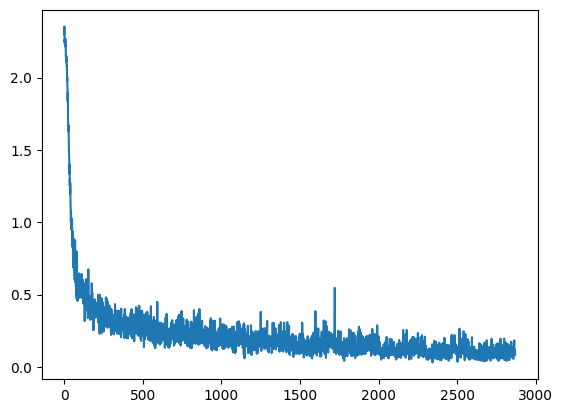

In [84]:
#Train MyModel
# my_model = MyModel(num_classes=10)
# my_model = IncSim()
# my_model = LongConvNet()
my_model = Proposal()
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(my_model.parameters(),lr = learning_rate)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

print('number of parameters: ' + str(compute_model_params(my_model)))

losses_list = train(my_model, train_loader, optimizer, num_epochs=10, model_name='proposal_sched_exp.ckpt', device=device,criterion=criterion)
plt.plot(losses_list)
plt.show()


In [ ]:
losses_list = train_hard(my_model, train_loader, optimizer, num_epochs=10, model_name='proposal_sched_exp.ckpt', device=device, scheduler="pepesito")
plt.plot(losses_list)
plt.show()

### Test your model
As a reference, 93% of accuracy can be easily achieved by using only ~55000 parameters.

In [85]:
# Show results for all the trained models
data_path = 'Data'
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

#
my_net = Proposal()
my_net.load_state_dict(torch.load(results_path + '/proposal_sched_exp.ckpt'))
my_net.cuda()
acc = test(my_net, test_loader) 

print('Accuracy MyNet: ' + str(acc))

Accuracy MyNet: 92.73970497848802


# Ex. 3

In [ ]:
'''
1. Use the implemented architecture in the previous exercice to solve the transfer learning
   task provided in the examples.
2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.
2. Report the test accuracy in each case and discuss the results. 
'''

## Sol. 3

### Initialize DataLoaders for Transfer Learning experiment

In [ ]:
# Big dataset with numbers from 1 to 8
SVHNTrain_TL = SVHN(data_path+'/svhn_tl/tl_train_32x32.mat',tr)
tl_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain_TL,
                                               batch_size=256, 
                                               shuffle=True)

# 200 samples of 0s and 9s
SVHNTrain_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_train_9_10_32x32.mat',tr)
tl_train_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTrain_TL_0_9,
                                                  batch_size=64, 
                                                  shuffle=True)
# Test dataset with 0 and 9s
SVHNTest_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_test_9_10_32x32.mat',tr)
tl_test_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTest_TL_0_9,
                                                  batch_size=64, 
                                                  shuffle=True)

### Pre-train your model with the big dataset with numbers from 1 to 8

In [ ]:
#Train ResNet
resnet_tl = MyModel(num_classes=8)
#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(resnet_tl.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet_tl = resnet_tl.to(device)

losses_it = train(resnet_tl, tl_train_loader, optimizer, num_epochs=10, model_name='tl_mynet_svhn.ckpt', device=device)


### Fine-tune the pretrained network with the small dataset of 9s and 0s